# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.


## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [ ]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Normalize the images (used in cifar10 and cifar100)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Invert normalization to print images
class NormalizeInverse(torchvision.transforms.Normalize):
    #Undoes the normalization and returns the reconstructed images in the input domain.
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv_norm = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

#### Cifar10 (ID)
CIFAR-10 is used as the in-distribution dataset.

In [ ]:
# Load the datasets and setup the DataLoaders.
batch_size = 256
ds_train_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train_cifar10 = torch.utils.data.DataLoader(ds_train_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test_cifar10 = torch.utils.data.DataLoader(ds_test_cifar10, batch_size=batch_size, shuffle=False, num_workers=2)

# Cifar10 classes
classes_cif10 = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 33877412.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Fake dataset (OOD)

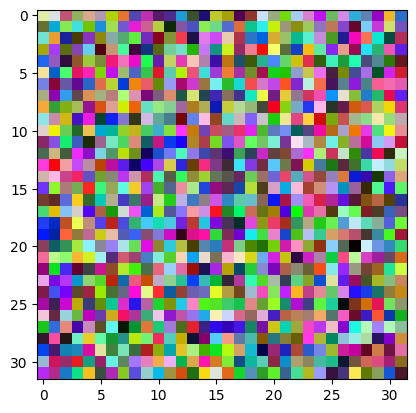

In [ ]:
# Fake dataset, a OOD dataset
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

# Plot a fake image.
plt.imshow(FakeData(size=1, image_size=(3, 32, 32))[0][0])

#### Cifar100 subset (OOD)

100%|██████████| 169001437/169001437 [00:03<00:00, 49188539.63it/s]


Extracting ./dataset/cifar-100-python.tar.gz to ./dataset
Cifar100 subset classes: ['bowl', 'chair', 'dolphin', 'lamp', 'otter', 'plain', 'tank', 'train', 'rose', 'bed']


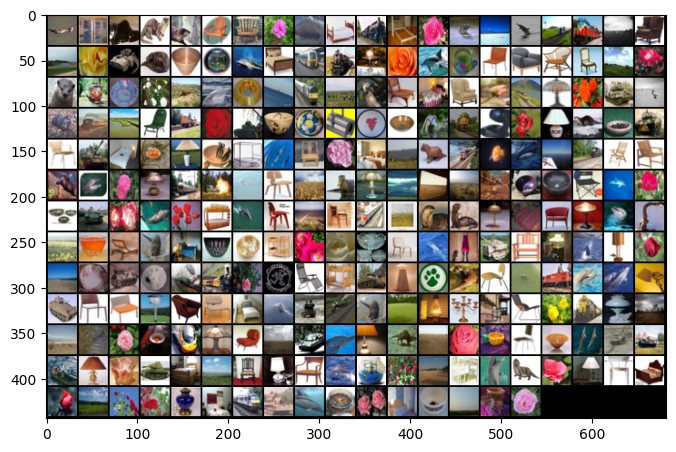

In [ ]:
from typing import List
from torchvision.datasets import CIFAR100
import torchvision

# Takes a list of indices (CIFAR100 classes) and creates a subset
class CIFAR100Subset(CIFAR100):
    def __init__(self, subset: List[int], **kwargs):
        super().__init__(**kwargs)
        self.subset = subset
        # Check indices
        assert max(subset) <= max(self.targets)
        assert min(subset) >= min(self.targets)
        # Selects the classes
        self.aligned_indices = []
        for idx, label in enumerate(self.targets):
            if label in subset:
                self.aligned_indices.append(idx)

    def get_class_names(self):
        return [self.classes[i] for i in self.subset]

    def __len__(self):
        return len(self.aligned_indices)

    def __getitem__(self, item):
        return super().__getitem__(self.aligned_indices[item])

# Get cifar100 subset, OOD dataset
ds_cifar100_subset = CIFAR100Subset(
    subset=[10, 20, 30, 40, 55, 60, 85, 90, 70, 5],
    root='./dataset',
    train=True,
    download=True,
    transform=transform
)

cifar100_sub_classes= ds_cifar100_subset.get_class_names()
print(f'Cifar100 subset classes: {cifar100_sub_classes}')

dl_cifar100 = torch.utils.data.DataLoader(ds_cifar100_subset, batch_size=batch_size, shuffle=True, num_workers=2)
# Showing some images
x, _ = next(iter(dl_cifar100))
grid_img = torchvision.utils.make_grid(inv_norm(x), nrow=20)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### CNN

In [ ]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
model.load_state_dict(torch.load('./cifar10_CNN.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# Train a model on a given dataloader for epochs. The input images can be adversarially attacked, data augmentation
def training(model, train_dataloader, epochs = 50, adversarial = None, name =""):
  # Train for only 50 epochs.
  epochs = epochs
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Main training loop.
  for epoch in range(epochs):
      running_loss = 0.0
      # Iterate over all batches.
      for (i, (Xs, ys)) in enumerate(train_dataloader, 0):
          Xs = Xs.to(device)
          ys = ys.to(device)
          # Create attacked images and modify the inputs and the labels
          if adversarial is not None:
            xs_attacked, _ = adversarial.attack(Xs, ys, model)
            # Original inputs and attacked inputs
            Xs = torch.cat((Xs, xs_attacked))
            # Both original and attacked inputs have the same labels
            ys = torch.cat((ys,ys))

          # Make a gradient step.
          optimizer.zero_grad()
          outputs = model(Xs)
          loss = criterion(outputs, ys)
          loss.backward()
          optimizer.step()

          # Track epoch loss.
          running_loss += loss.item()

      # Print average epoch loss.
      print(f'{epoch + 1} loss: {running_loss / len(dl_train_cifar10):.3f}')

  print('Finished Training')
  torch.save(model.state_dict(), './cifar10_CNN'+name+'.pth')

In [ ]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)
training(model, dl_train_cifar10, epochs = 50)


In [ ]:
from sklearn.metrics import  confusion_matrix
import pandas as pd
import seaborn as sn

# Test the model on a given test dataloader. The images can be adversarially attacked
def testing(model, test_dataloader, adversarial = None):
  # Test the model
  model.eval()
  # Accumulate the number of total and correct predictions, ground truths and predictions for the confusion matrix
  correct = 0
  total = 0
  predictions = []
  ground_truths = []
  for data in test_dataloader:
      images, targets = data
      # Collect the ground truths
      ground_truths.extend(targets.detach().cpu().numpy())
      # Attack the images before feeding them to the model
      if adversarial is not None:
        images, _ = adversarial.attack(images,targets, model)
      images, targets = images.to(device), targets.to(device)
      # Calculate outputs by running images through the network
      logits = model(images)
      # The class with the highest energy is what we choose as prediction
      _, predicted = torch.max(logits.data, 1)
      # Collect the predictions
      predictions.extend(predicted.detach().cpu().numpy())
      # Update the number of all the targets and correct predictions
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  print(f'Test accuracy of the network: {100 * correct / total} %')

  # Build and print confusion matrix
  cf_matrix = confusion_matrix(ground_truths, predictions)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes_cif10],
                  columns = [i for i in classes_cif10])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)

Test accuracy of the network: 60.29 %


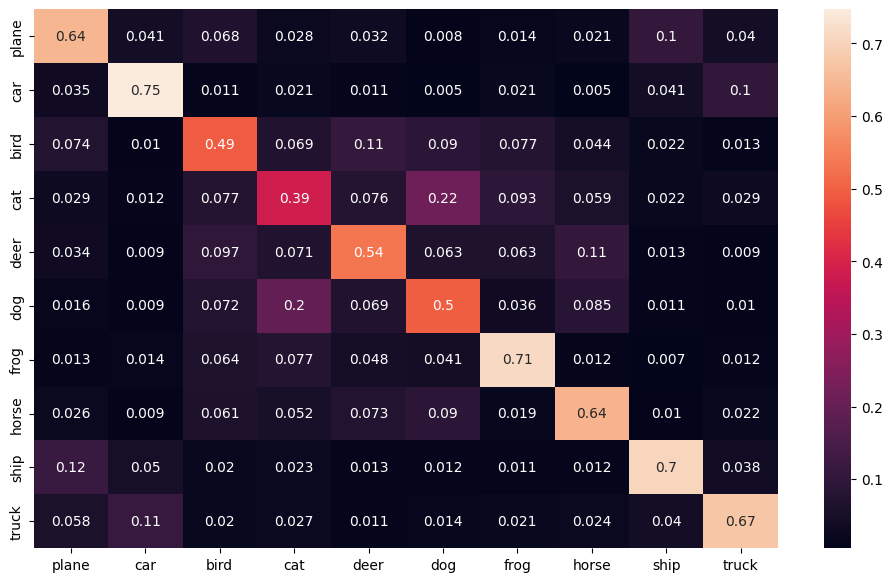

In [ ]:
testing(model, dl_test_cifar10)

#### Compute scores
Showing the distributions of different scoring functions of logits that the model generates with ID or OOD datasets.

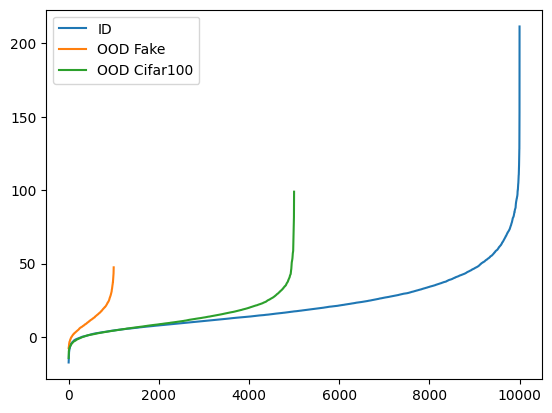

In [ ]:
# Get max logit
def max_logit(logit):
    return  logit.max(dim=1)[0]

# Get max after softmax
def max_softmax(logit, T):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0]
    return s


# Compute scores given a model, dataloader and a scoring function
def compute_scores(model, dataloader, score_fun):
    scores = []
    with torch.no_grad():
      for data in dataloader:
          images, targets = data
          images = images.to(device)
          logit = model (images)
          s = score_fun(logit)
          scores.append(s)
    scores_t = torch.cat(scores)
    return scores_t

# With max logit
scores_cif10 = compute_scores(model, dl_test_cifar10, max_logit)
scores_fake = compute_scores(model, dl_fake, max_logit)
scores_cif100 = compute_scores(model, dl_cifar100, max_logit)

plt.plot(sorted(scores_cif10.detach().cpu()), label='ID')
plt.plot(sorted(scores_fake.detach().cpu()), label='OOD Fake')
plt.plot(sorted(scores_cif100.detach().cpu()), label='OOD Cifar100')
plt.legend()

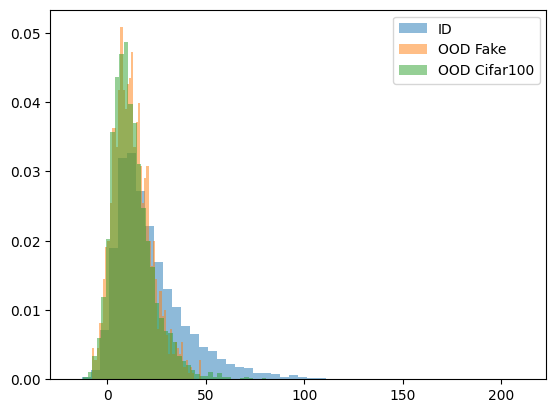

In [ ]:
_ = plt.hist(scores_cif10.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

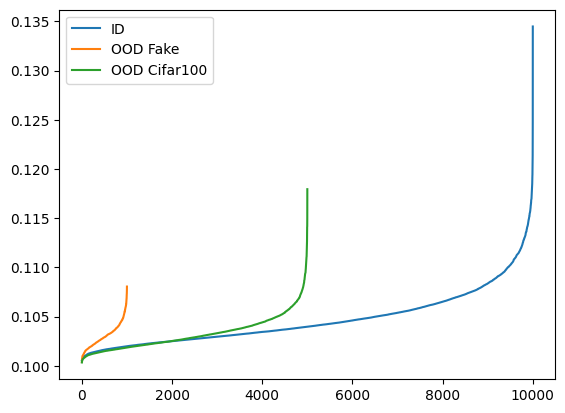

In [ ]:
temp = 1000
# With max softmax
scores_cif10_soft = compute_scores(model, dl_test_cifar10, lambda l: max_softmax(l, T=temp))
scores_fake_soft = compute_scores(model, dl_fake, lambda l: max_softmax(l, T=temp))
scores_cif100_soft = compute_scores(model, dl_cifar100, lambda l: max_softmax(l, T=temp))

plt.plot(sorted(scores_cif10_soft.detach().cpu()), label='ID')
plt.plot(sorted(scores_fake_soft.detach().cpu()), label='OOD Fake')
plt.plot(sorted(scores_cif100_soft.detach().cpu()), label='OOD Cifar100')
plt.legend()

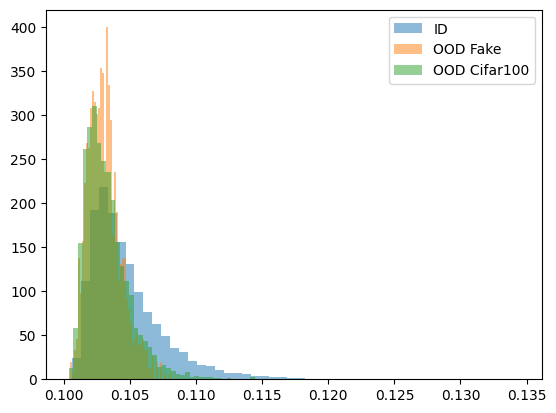

In [ ]:
_ = plt.hist(scores_cif10_soft.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_soft.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100_soft.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

We can cleary see in both cases (max logit and softmax) that the OOD distributions and the ID distribution are not easy to distinguish, the model returns similar logits and softmax for every distribution.

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


#### ROC Curve
Produce ROC curve and display it using the scores (max logit or softmax) and the ground truths (if the data is from an ID or OOD dataset).

The ROC curve depicts the relationship  between TPR (True Positive Rate) and FPR (False Positive Rate).

Its AUC (Area Under the Curve) can be interpreted as the probability that a positive example (ID) is assigned a higher detection score than a negative example (OOD).



In [ ]:
from sklearn import metrics

def create_display_ROC(scores_id, scores_ood):
  ypred = torch.cat((scores_id, scores_ood))
  y_id = torch.ones_like(scores_id)
  y_ood = torch.zeros_like(scores_ood)
  y_true = torch.cat((y_id, y_ood))

  # ROC curve given true labels and predicted label
  metrics.RocCurveDisplay.from_predictions(y_true.cpu(), ypred.cpu())

CIFAR10 and FAKE data

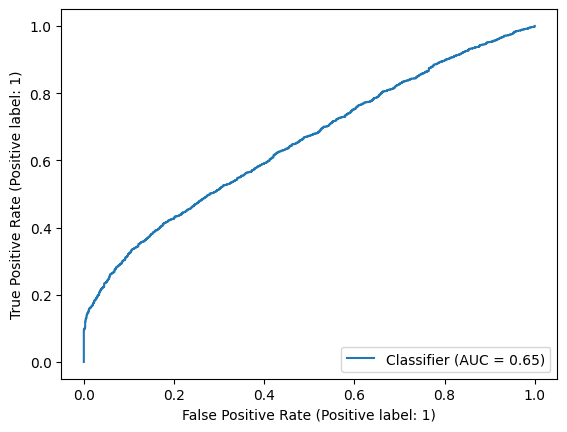

In [ ]:
create_display_ROC(scores_cif10, scores_fake)

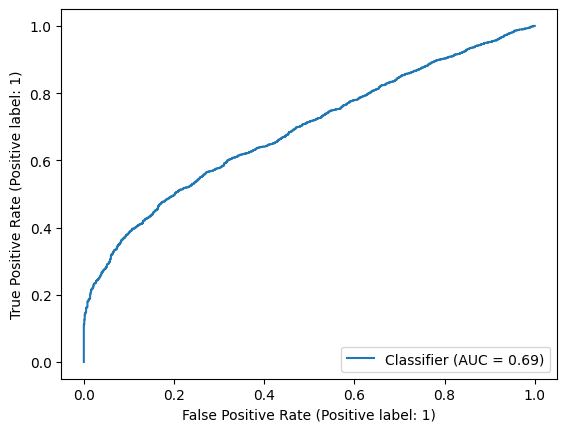

In [ ]:
create_display_ROC(scores_cif10_soft, scores_fake_soft)

CIFAR10 and CIFAR100

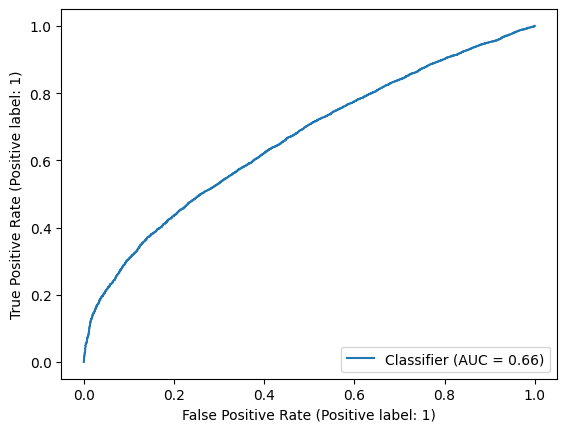

In [ ]:
create_display_ROC(scores_cif10, scores_cif100)

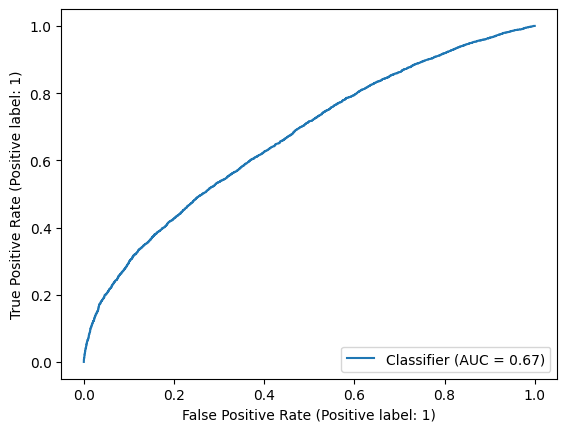

In [ ]:
create_display_ROC(scores_cif10_soft, scores_cif100_soft)

Using the softmax we get a slightly better ROC curve when the OOD
dataset is Fake Data. There is no such change in the ROC curve when the OOD dataset is a subset of CIFAR100

#### PR Curve
Produce PR curve and display it using the scores (max logit or softmax) and the ground truths (if the data is from an ID or OOD dataset).

The PR curve shows the precision = TP/(TP+FP) and recall = TP/(TP/FN) against each other.

AP = Average Precision.

In [ ]:
from sklearn import metrics

def create_display_PR(scores_id, scores_ood):
  ypred = torch.cat((scores_id, scores_ood))
  y_id = torch.ones_like(scores_id)
  y_ood = torch.zeros_like(scores_ood)
  y_true = torch.cat((y_id, y_ood))

  # Precision Recall curve given true labels and predicted label
  metrics.PrecisionRecallDisplay.from_predictions(y_true.cpu(), ypred.cpu())

CIFAR10 and FAKE data

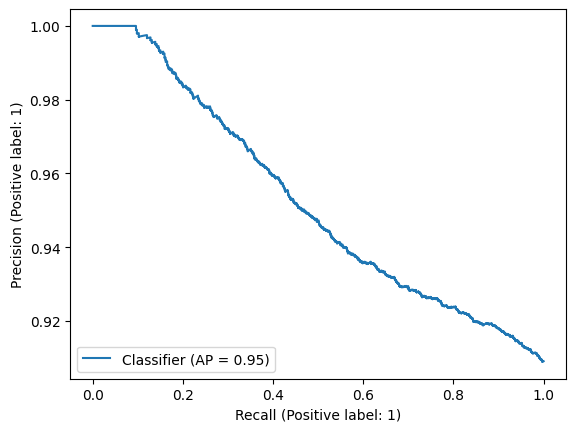

In [ ]:
create_display_PR(scores_cif10, scores_fake)

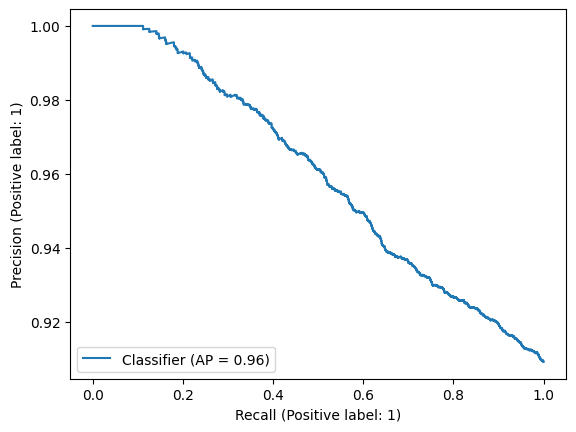

In [ ]:
create_display_PR(scores_cif10_soft, scores_fake_soft)

CIFAR10 and CIFAR100

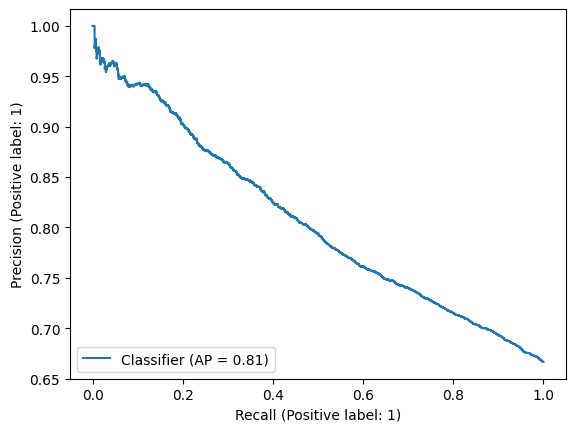

In [ ]:
create_display_PR(scores_cif10, scores_cif100)

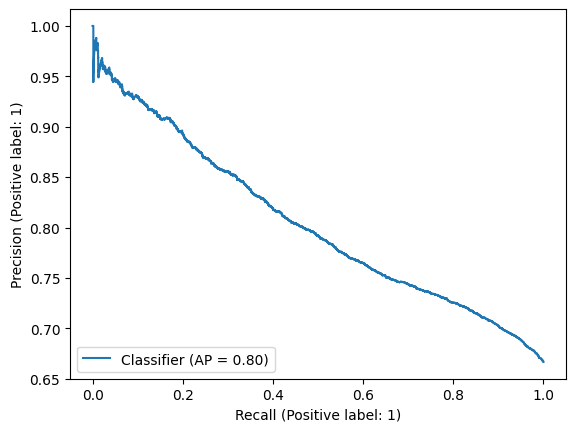

In [ ]:
create_display_PR(scores_cif10_soft, scores_cif100_soft)

Once again, using the softmax we get a slightly improved PR curve when the OOD dataset is Fake Data. The PR curve corresponding to the CIFAR100 dataset does not change with the scoring function and seems a lot worse than the Fake Data one, meaning that is probably harder for the CNN to distinguish CIFAR100 from CIFAR10 than Fake Data from CIFAR10.

## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

In [ ]:
# Implementation of FGSM on a batch of images (and their labels) given a model, epsilon and
# the number of steps (how many "adversarial steps" to take)
class FGSM:
  def __init__(self, epsilon, num_steps = 5):
    self.epsilon = epsilon
    self.num_steps = num_steps

  def attack(self, images, labels, model):
    model.train()
    # Don't modify original images or labels
    images = images.clone().detach().to(device)
    labels = labels.clone().detach().to(device)

    loss = nn.CrossEntropyLoss()
    # To calculate gradient
    images.requires_grad = True
    for _ in range(self.num_steps):
      # To make grad calculation possible
      images.retain_grad()

      outputs = model(images)
      # Calculate loss
      cost = loss(outputs, labels)

      # Computes and returns the sum of gradients of outputs with respect to the inputs.
      grad = torch.autograd.grad(cost, images, retain_graph=False)[0]

      # Update adversarial images
      images = images + self.epsilon * grad.sign()
    model.eval()
    return images, outputs

In [ ]:
# Show the changes between an image and the same image after the adversarial attack
def Compare_img(image, first_out, adv_image, output):
  # Show the original image and its predicted class
  print(f'Original image and original predicted class')
  img = inv_norm(image)
  plt.imshow(img.permute(1,2,0))
  plt.title(classes_cif10[first_out.argmax()])
  plt.show()

  print(f'Image and predicted class after the adversarial attack')
  # Show the image and its predicted class after the adversarial attack
  img_adv = inv_norm(adv_image)
  plt.imshow(img_adv.permute(1,2,0).detach().cpu())
  plt.title(classes_cif10[output.argmax()])
  plt.show()

  print(f'Absolute difference between the two images')
  # Computes the absolute value of the difference between the two images and shows it
  diff = torch.abs(adv_image.detach().cpu()-image)
  diff_inv = inv_norm(diff)
  plt.imshow(diff_inv.permute(1,2,0))
  plt.title('diff')
  plt.show()
  print(f'Histogram with the difference of the two images on a pixel level')
  # Show an histogram with the difference between the two images on a pixel level
  diff_flat = diff.flatten()
  plt.hist(diff_flat)

#### Epsilon = 0.002

Original image and original predicted class


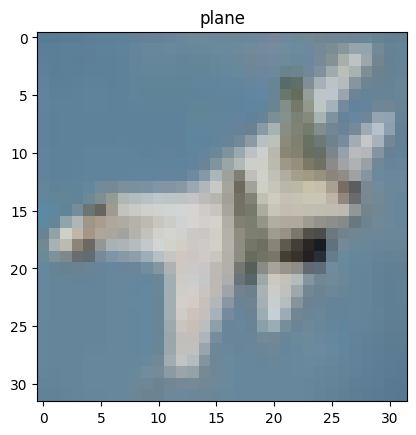

Image and predicted class after the adversarial attack


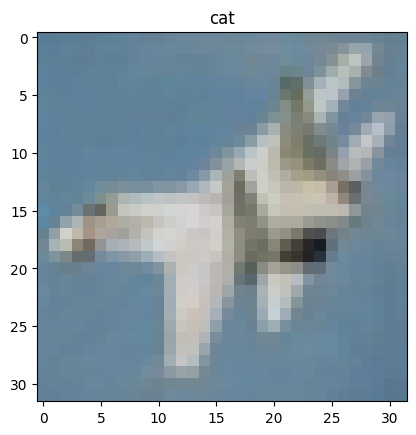

Absolute difference between the two images


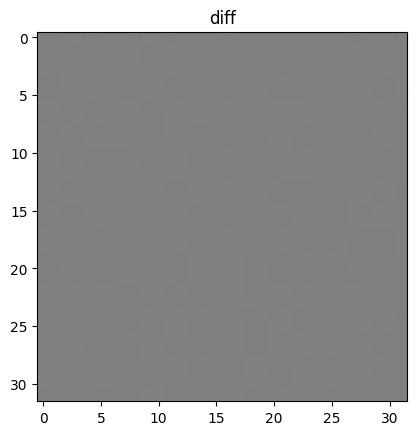

Histogram with the difference of the two images on a pixel level


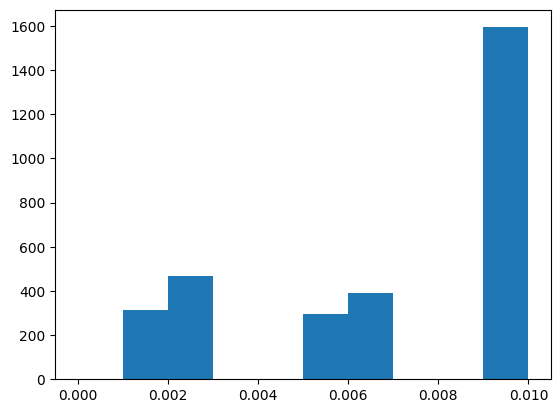

In [ ]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

As we can see the attacked image does change label while the attack is not really noticeable ( the difference between the two images is really small).

Test accuracy of the network: 22.12 %


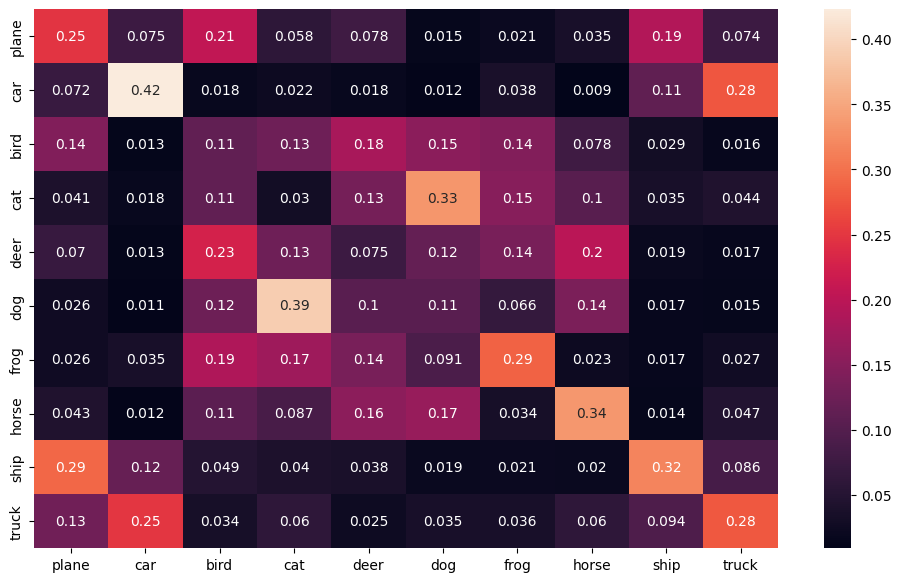

In [ ]:
# Evaluate the model performance on attacked images
testing(model, dl_test_cifar10, fgsm)

Testing the model on the attacked test images shows that the attacks are indeed working. For comparison, the previous test accuracy on the corresponding (not attacked) test images was 60.29%. The network's ability to correctly predict an image's label deteriorated considerably.

#### Epsilon = 0.0006

Original image and original predicted class


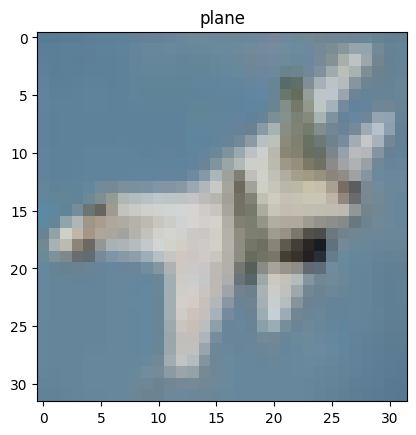

Image and predicted class after the adversarial attack


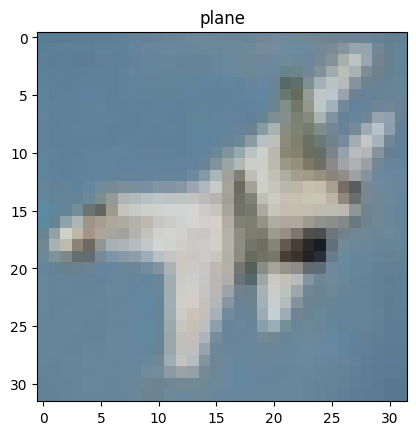

Absolute difference between the two images


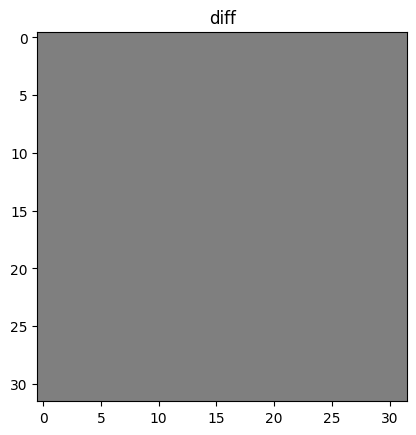

Histogram with the difference of the two images on a pixel level


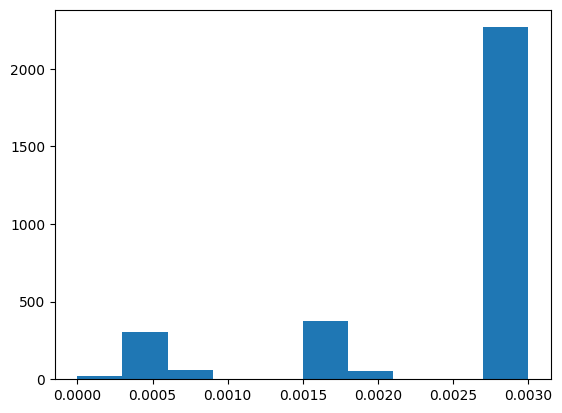

In [ ]:
# Smaller epsilon
eps = 0.0006

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Using a smaller epsilon makes the attack even more difficult to notice but also renders it useless, the image's label does not change

Test accuracy of the network: 42.81 %


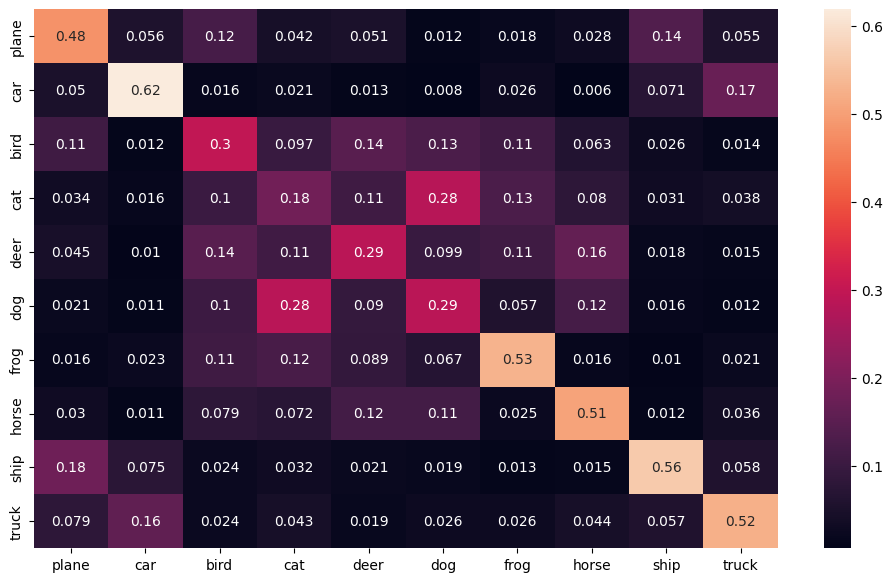

In [ ]:
# Evaluate the model performance on attacked images
testing(model, dl_test_cifar10, fgsm)

Given the weaker attack, the network's accuracy (previously 60.29%) does deteriorate but less than before.

Using a lower epsilon makes the attack less effective and less noticeable. Since the previous attack was already not easy to spot, having a stronger negative effect on the network's performances makes using epsilon = 0.002 a better choice.

#### Epsilon = 0.008

Original image and original predicted class


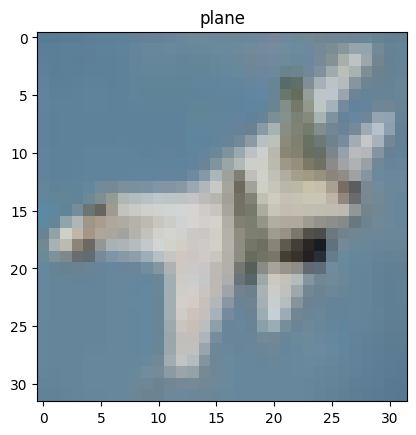

Image and predicted class after the adversarial attack


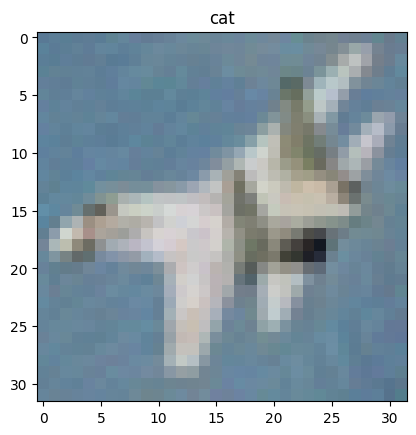

Absolute difference between the two images


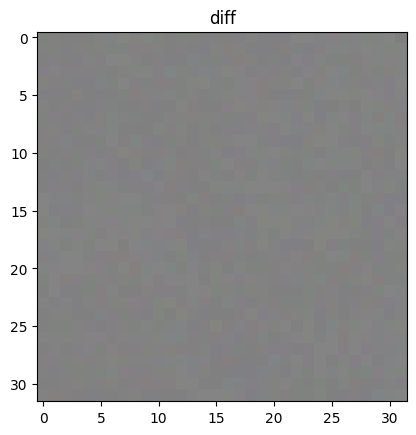

Histogram with the difference of the two images on a pixel level


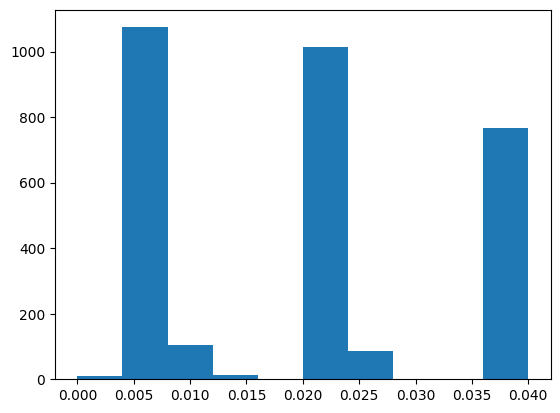

In [ ]:
#Bigger epsilon
eps = 0.008

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model)

# Select a particular image to show the result
id_image=10
# Calculate first output of the model given the real image
first_out = model(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Using a bigger epsilon makes the attack a lot more obvious. The attacked image does have a different label than the original, but it looks extremely noisy.

Test accuracy of the network: 5.05 %


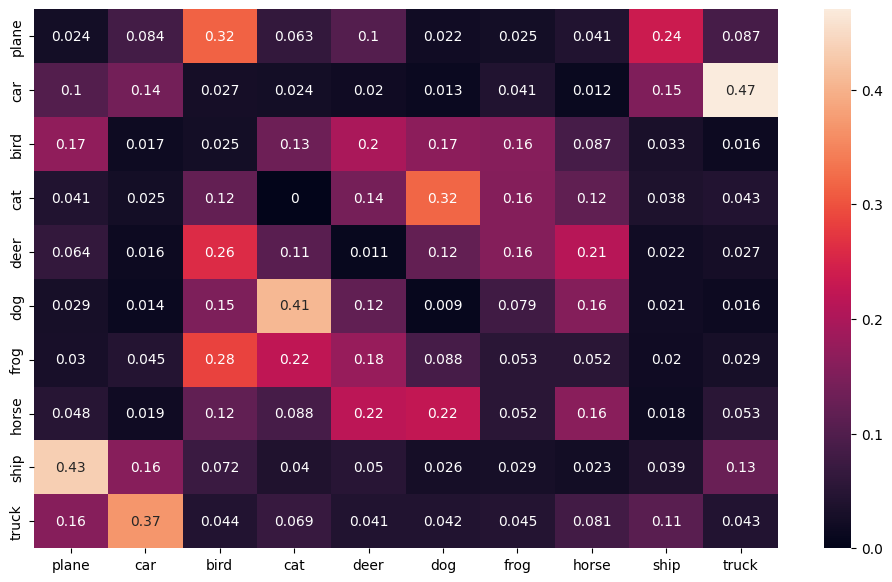

In [ ]:
# Evaluate the model performance on attacked images
testing(model, dl_test_cifar10, fgsm)

With a stronger attack the network's accuracy is completely destroyed.

A stronger attack is more noticeable, most humans could tell that there is something wrong with the attacked image. Considering this, once again, the attack that uses epsilon = 0.002 is preferrable, since it does worsen the network's accuracy while making the attack "invisible".

## Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

### Epsilon = 0.002
Using the attack that was deemed the best in the previous subsection, I attacked the training images and concatenated them to the original images while training from scratch the same CNN used before.



In [ ]:
# Define epsilon, FGSM and model
eps = 0.002
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv = CNN().to(device)

# Train the model from scratch whith adversarial samples
training(model_adv, dl_train_cifar10, epochs = 50, adversarial =fgsm, name = "_adversarial")


1 loss: 1.883
2 loss: 1.602
3 loss: 1.505
4 loss: 1.443
5 loss: 1.397
6 loss: 1.359
7 loss: 1.328
8 loss: 1.298
9 loss: 1.274
10 loss: 1.250
11 loss: 1.234
12 loss: 1.213
13 loss: 1.192
14 loss: 1.173
15 loss: 1.162
16 loss: 1.142
17 loss: 1.131
18 loss: 1.116
19 loss: 1.103
20 loss: 1.090
21 loss: 1.082
22 loss: 1.068
23 loss: 1.062
24 loss: 1.055
25 loss: 1.040
26 loss: 1.030
27 loss: 1.023
28 loss: 1.017
29 loss: 1.008
30 loss: 1.002
31 loss: 0.996
32 loss: 0.988
33 loss: 0.981
34 loss: 0.977
35 loss: 0.967
36 loss: 0.965
37 loss: 0.954
38 loss: 0.953
39 loss: 0.946
40 loss: 0.941
41 loss: 0.934
42 loss: 0.930
43 loss: 0.925
44 loss: 0.922
45 loss: 0.919
46 loss: 0.913
47 loss: 0.908
48 loss: 0.906
49 loss: 0.900
50 loss: 0.895
Finished Training


In [ ]:
# Load the trained model
model_adv = CNN().to(device)
model_adv.load_state_dict(torch.load('./cifar10_CNN_adversarial.pth', map_location=torch.device(device)))

<All keys matched successfully>

Test accuracy of the network: 63.33 %


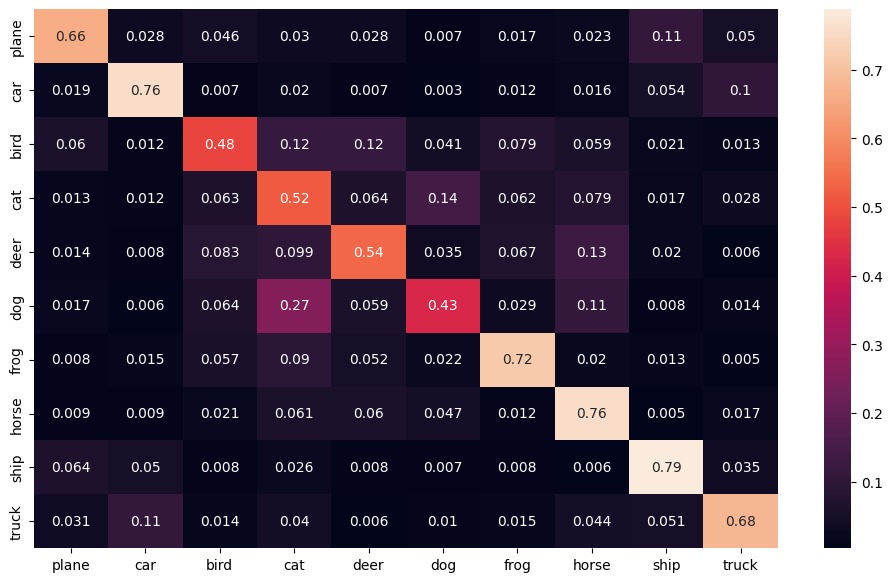

In [ ]:
# Test the model on regular test images
testing(model_adv, dl_test_cifar10)

Testing the model on the original test images we can see that the performance is slightly improved (original test accuracy: 60.29%). Attacking the training images is a form of data augmentation and the CNN was indeed trained on double the original images.

#### Compute scores

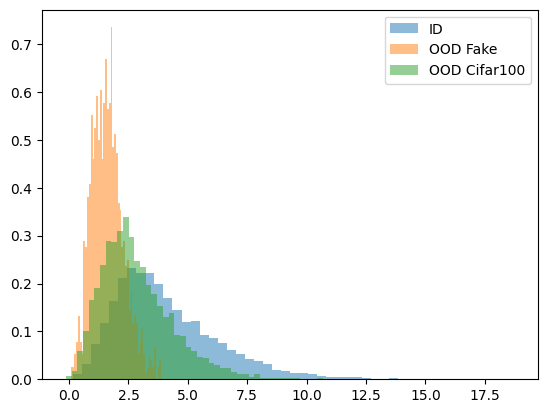

In [ ]:
# With max logit
scores_cif10_adv = compute_scores(model_adv, dl_test_cifar10, max_logit)
scores_fake_adv = compute_scores(model_adv, dl_fake, max_logit)
scores_cif100_adv = compute_scores(model_adv, dl_cifar100, max_logit)
_ = plt.hist(scores_cif10_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

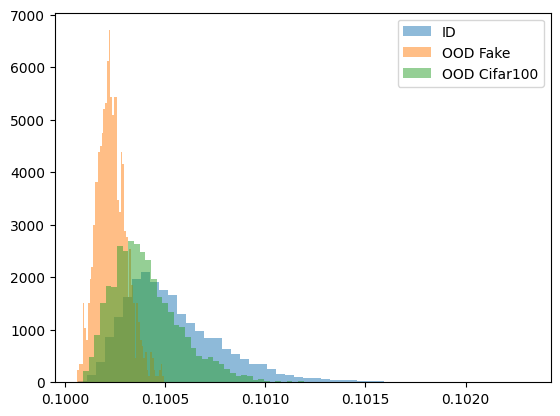

In [ ]:
temp = 1000
# With max softmax
scores_cif10_soft_adv = compute_scores(model_adv, dl_test_cifar10, lambda l: max_softmax(l, T=temp))
scores_fake_soft_adv = compute_scores(model_adv, dl_fake, lambda l: max_softmax(l, T=temp))
scores_cif100_soft_adv = compute_scores(model_adv, dl_cifar100, lambda l: max_softmax(l, T=temp))
_ = plt.hist(scores_cif10_soft_adv.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_soft_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100_soft_adv.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

Comparing these histograms with the ones in the first section we can distinctly see that the OOD Fake data distribution and the ID CIFAR10 distribution are more separated and distinguishable.

The CIFAR10 and CIFAR100 distribution do seem still very similar.

#### ROC Curve




CIFAR10 and FAKE data

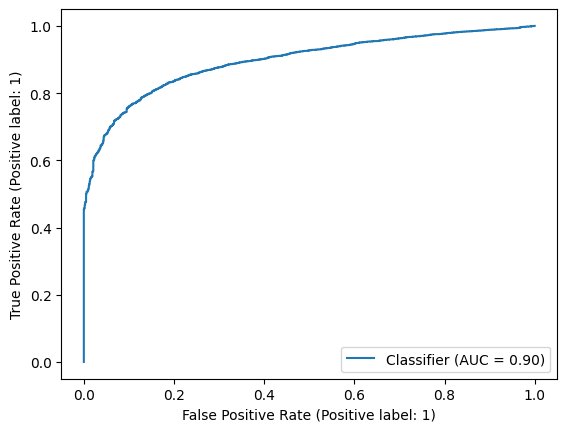

In [ ]:
create_display_ROC(scores_cif10_adv, scores_fake_adv)

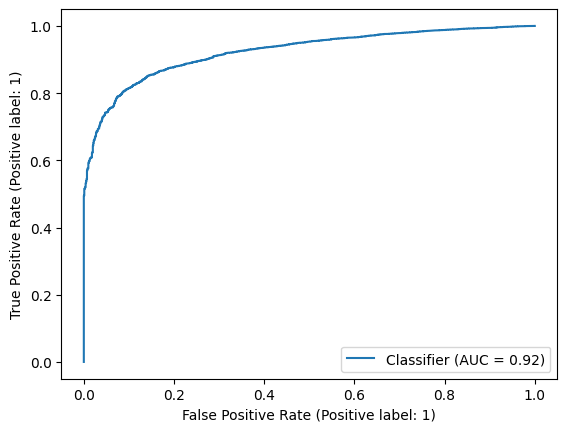

In [ ]:
create_display_ROC(scores_cif10_soft_adv, scores_fake_soft_adv)

Observing the AUC scores (0.65 and 0.69 in the first section) we can tell that the model is now mostly able to assign a higher detection score to the images in the ID dataset compared to the OOD images.

CIFAR10 and CIFAR100

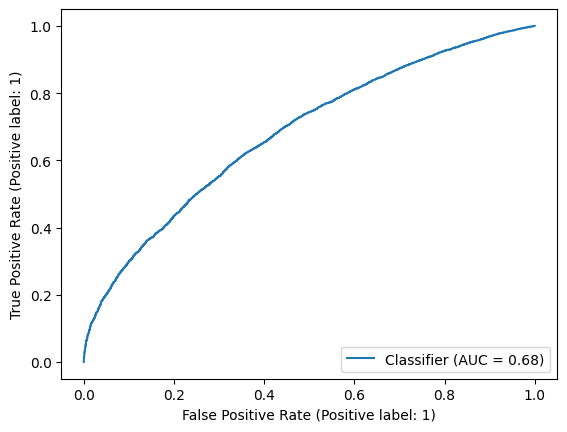

In [ ]:
create_display_ROC(scores_cif10_adv, scores_cif100_adv)

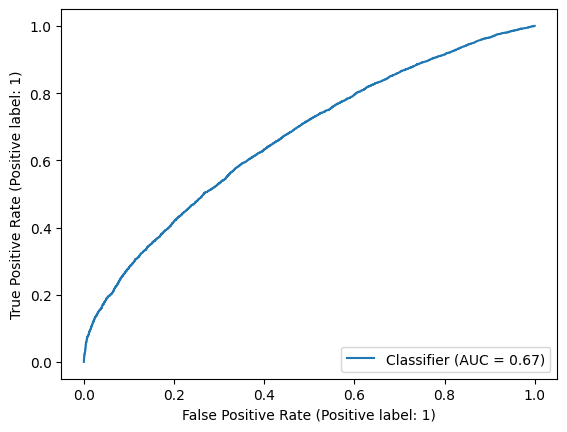

In [ ]:
create_display_ROC(scores_cif10_soft_adv, scores_cif100_soft_adv)

The same is not really true when the OOD dataset is CIFAR100 (0.66 and 0.67 in the first section). It probably still is too similar to the attacked CIFAR10 images.

#### PR Curve


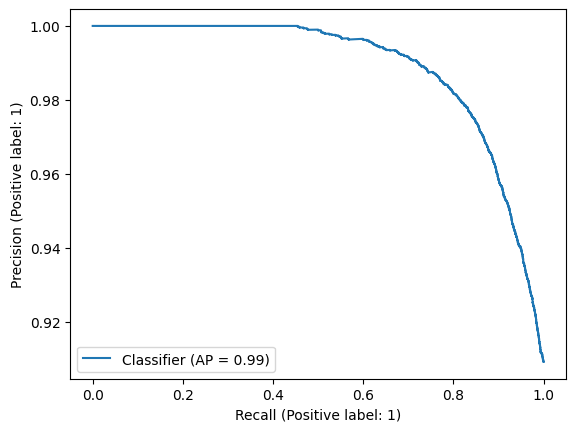

In [ ]:
create_display_PR(scores_cif10_adv, scores_fake_adv)

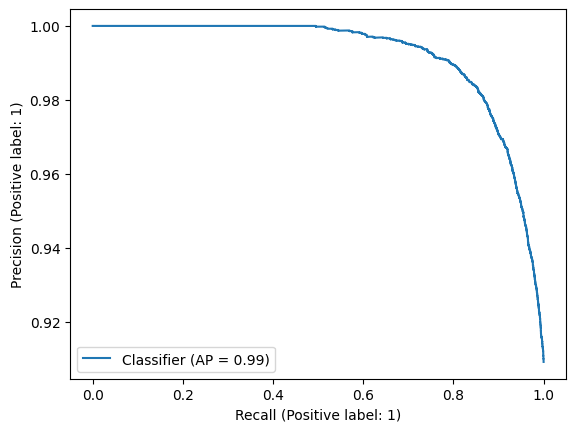

In [ ]:
create_display_PR(scores_cif10_soft_adv, scores_fake_soft_adv)

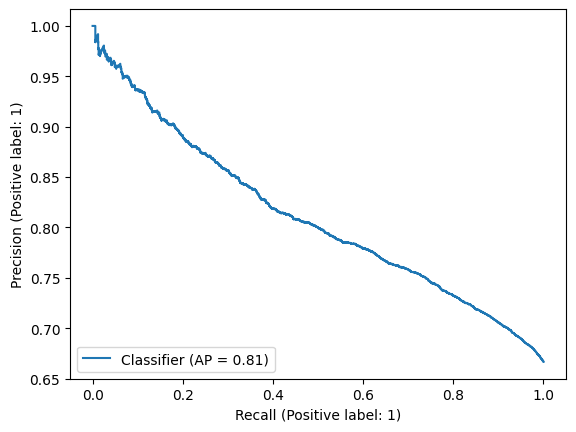

In [ ]:
create_display_PR(scores_cif10_adv, scores_cif100_adv)

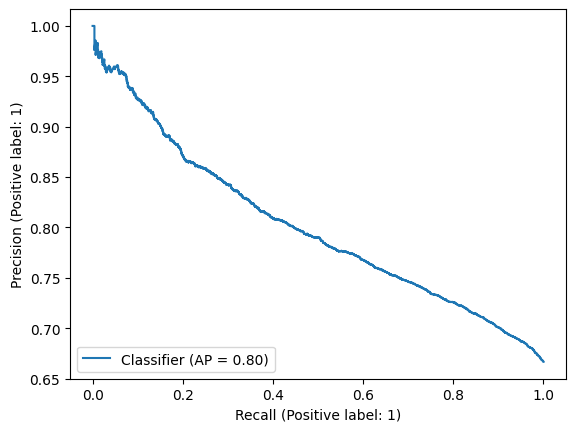

In [ ]:
create_display_PR(scores_cif10_soft_adv, scores_cif100_soft_adv)

The PR curve confirms that the model is now more capable of telling that the Fake Data images are OOD (the PR curves are almost perfect) but is still not really suited to tell whether or not a CIFAR100 image is OOD.

Attacking the training images seems to make the network more resistant to noise.

This behavior  is not really surprising since Fake Data images are clearly more easily recognized as not similar to CIFAR10 images than CIFAR100 images.

#### Adversarial attacks
Use the same adversarial attack used to train the new model and test if they still work.

Original image and original predicted class


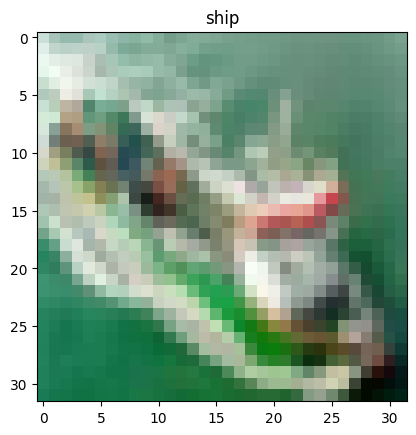

Image and predicted class after the adversarial attack


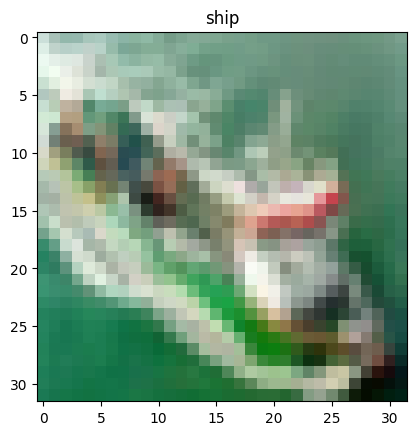

Absolute difference between the two images


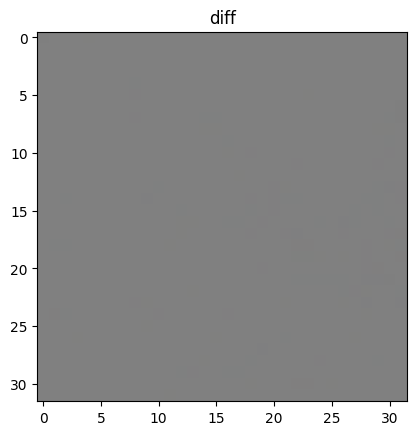

Histogram with the difference of the two images on a pixel level


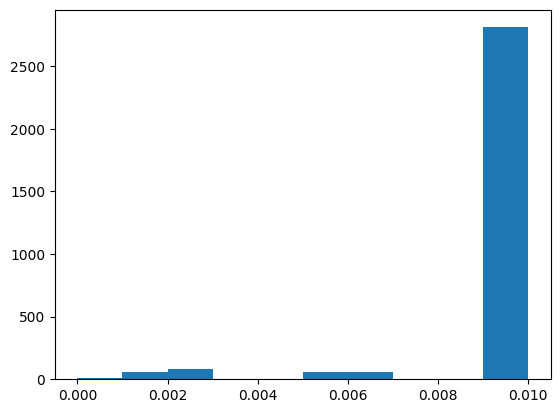

In [ ]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Test accuracy of the network: 47.77 %


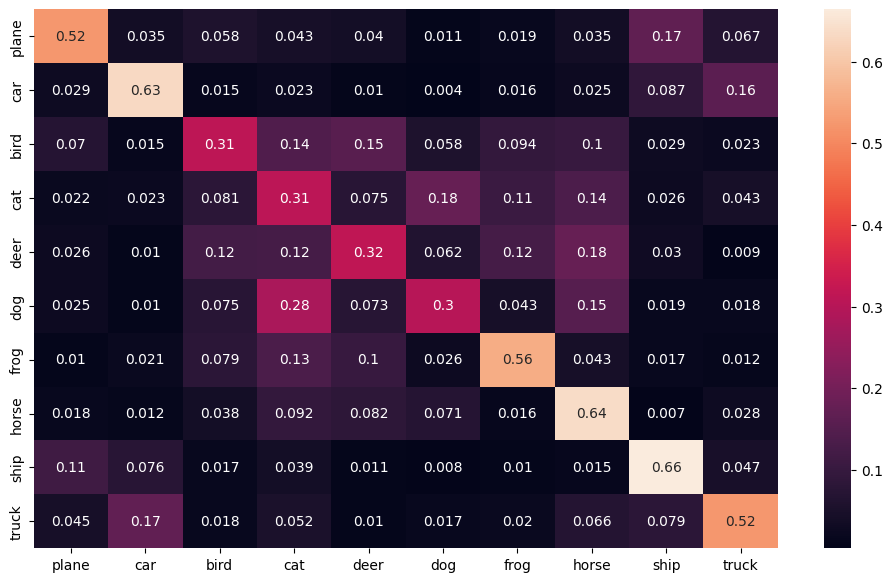

In [ ]:
# Test the model on attacked test images
testing(model_adv, dl_test_cifar10, fgsm)

Testing the model on the attacked test images shows that the model is now more robust to adversarial attacks (the test accuracy did deteriorate but less than before: from  63.33% to 47.77% instead of from 60.29% to 22.12%)

Stronger Attack

Original image and original predicted class


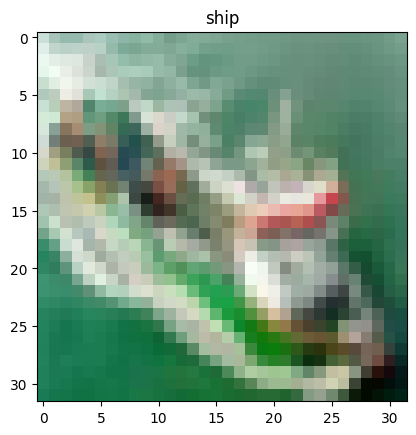

Image and predicted class after the adversarial attack


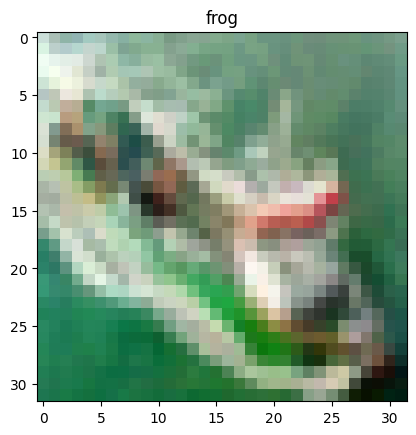

Absolute difference between the two images


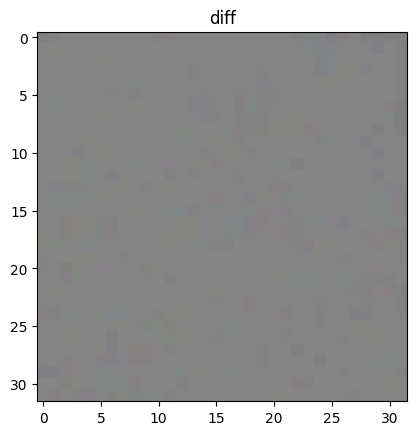

Histogram with the difference of the two images on a pixel level


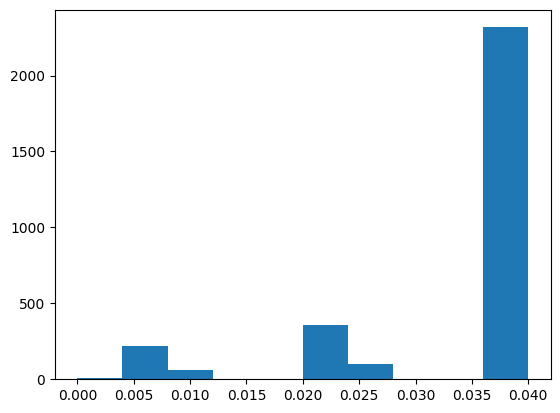

In [ ]:
# Bigger epsilon
eps = 0.008

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv)

# Select a particular image to show the result
id_image=15
# Calculate first output of the model given the real image
first_out = model_adv(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Test accuracy of the network: 14.37 %


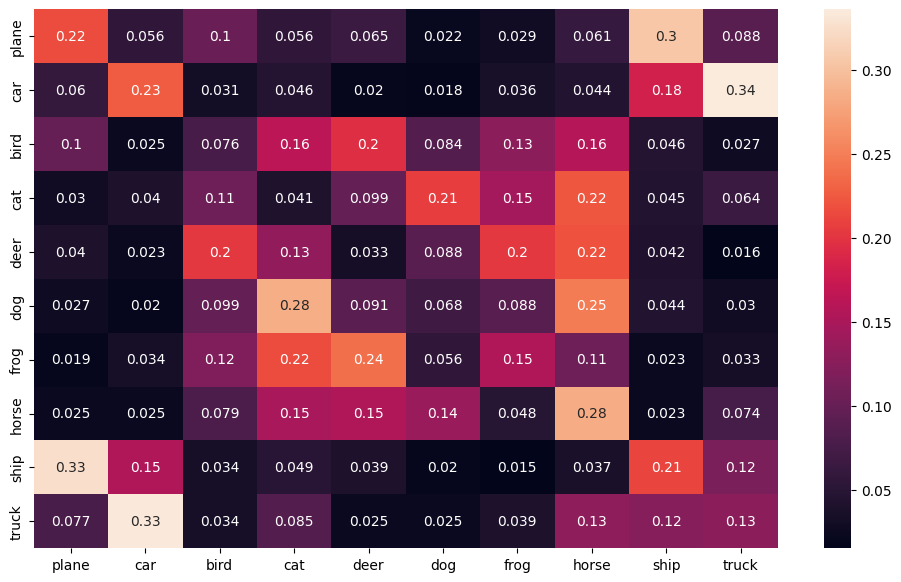

In [ ]:
# Test the model on attacked test images
testing(model_adv, dl_test_cifar10, fgsm)

Using a stronger attack in the test images than the one used to train the model leads to a significant test accuracy deterioration (from 63.33% to 14.37%) but this model is still more robust than the model trained only on the original images (from 60.29% to 5.05%).

### Epsilon 0.008
In this subsection I decided to test the effect that training from scratch a model using a stronger adversarial attack would have on its performances.

In [ ]:
# Define bigger epsilon, FGSM and model
eps = 0.008
fgsm = FGSM(epsilon = eps, num_steps = 5)
model_adv_strong = CNN().to(device)

# Train the model from scratch whith adversarial samples
training(model_adv_strong, dl_train_cifar10, epochs = 50, adversarial =fgsm, name = "_stronger_adv")


1 loss: 2.020
2 loss: 1.806
3 loss: 1.734
4 loss: 1.689
5 loss: 1.660
6 loss: 1.633
7 loss: 1.610
8 loss: 1.593
9 loss: 1.578
10 loss: 1.566
11 loss: 1.554
12 loss: 1.544
13 loss: 1.538
14 loss: 1.531
15 loss: 1.523
16 loss: 1.515
17 loss: 1.512
18 loss: 1.503
19 loss: 1.496
20 loss: 1.499
21 loss: 1.486
22 loss: 1.482
23 loss: 1.477
24 loss: 1.476
25 loss: 1.468
26 loss: 1.466
27 loss: 1.463
28 loss: 1.459
29 loss: 1.453
30 loss: 1.451
31 loss: 1.445
32 loss: 1.446
33 loss: 1.443
34 loss: 1.444
35 loss: 1.436
36 loss: 1.438
37 loss: 1.432
38 loss: 1.432
39 loss: 1.426
40 loss: 1.427
41 loss: 1.424
42 loss: 1.421
43 loss: 1.420
44 loss: 1.418
45 loss: 1.418
46 loss: 1.412
47 loss: 1.408
48 loss: 1.408
49 loss: 1.409
50 loss: 1.410
Finished Training


In [ ]:
# Load the trained model
model_adv_strong = CNN().to(device)
model_adv_strong.load_state_dict(torch.load('./cifar10_CNN_stronger_adv.pth', map_location=torch.device(device)))

Test accuracy of the network: 59.18 %


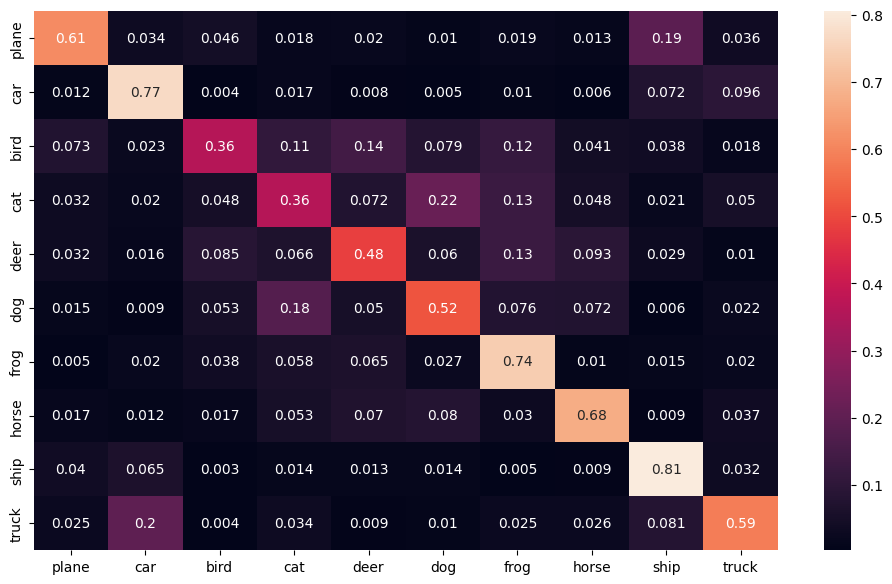

In [ ]:
# Test the model on regular test images
testing(model_adv_strong, dl_test_cifar10)

The model's test accuracy is a little lower than before (60.29% and 63.33%). This is probably due to stronger data augmentation that needed more epochs.

#### Compute scores

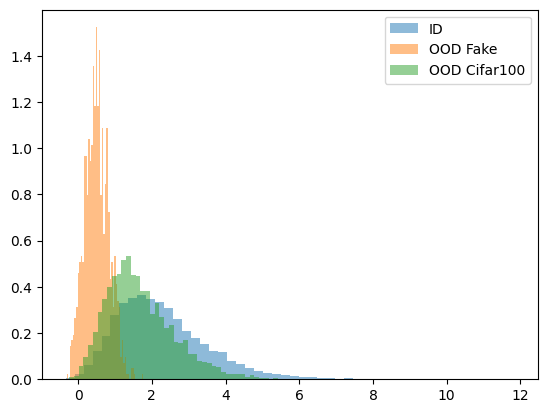

In [ ]:
# With max logit
scores_cif10_adv_strong = compute_scores(model_adv_strong, dl_test_cifar10, max_logit)
scores_fake_adv_strong = compute_scores(model_adv_strong, dl_fake, max_logit)
scores_cif100_adv_strong = compute_scores(model_adv_strong, dl_cifar100, max_logit)
_ = plt.hist(scores_cif10_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

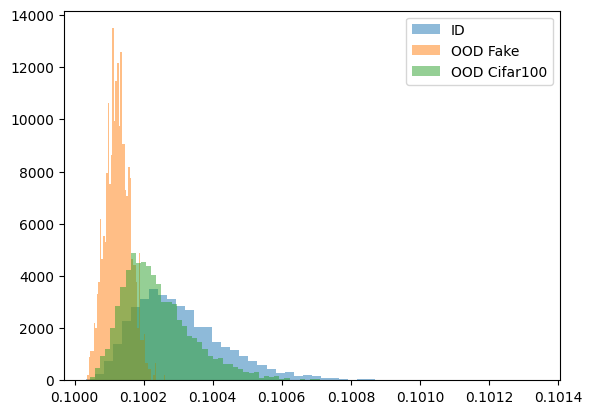

In [ ]:
temp = 1000
# With max softmax
scores_cif10_soft_adv_strong = compute_scores(model_adv_strong, dl_test_cifar10, lambda l: max_softmax(l, T=temp))
scores_fake_soft_adv_strong = compute_scores(model_adv_strong, dl_fake, lambda l: max_softmax(l, T=temp))
scores_cif100_soft_adv_strong = compute_scores(model_adv_strong, dl_cifar100, lambda l: max_softmax(l, T=temp))
_ = plt.hist(scores_cif10_soft_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake_soft_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(scores_cif100_soft_adv_strong.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

Once again, the Fake Data distribution is mostly distinguishable from the CIFAR10 distribution, while CIFAR100 and CIFAR10's distributions share a lot of values.

#### ROC Curve




CIFAR10 and FAKE data

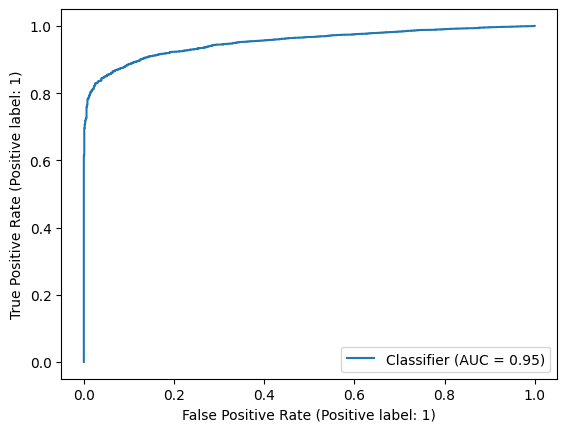

In [ ]:
create_display_ROC(scores_cif10_adv_strong, scores_fake_adv_strong)

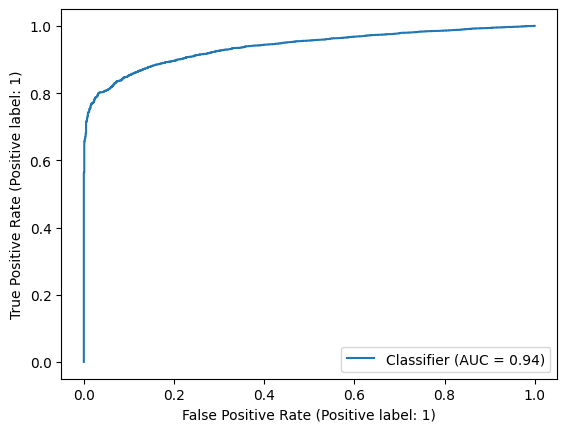

In [ ]:
create_display_ROC(scores_cif10_soft_adv_strong, scores_fake_soft_adv_strong)

CIFAR10 and CIFAR100

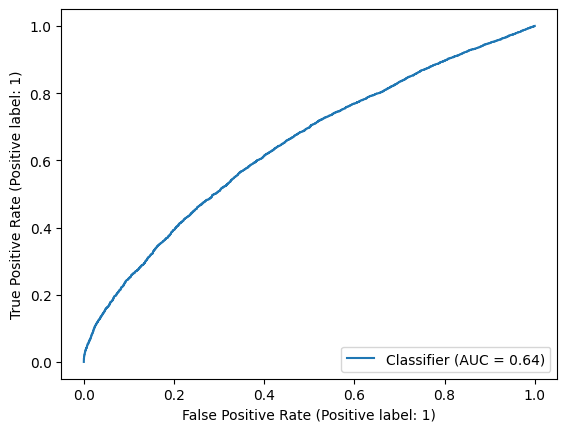

In [ ]:
create_display_ROC(scores_cif10_adv_strong, scores_cif100_adv_strong)

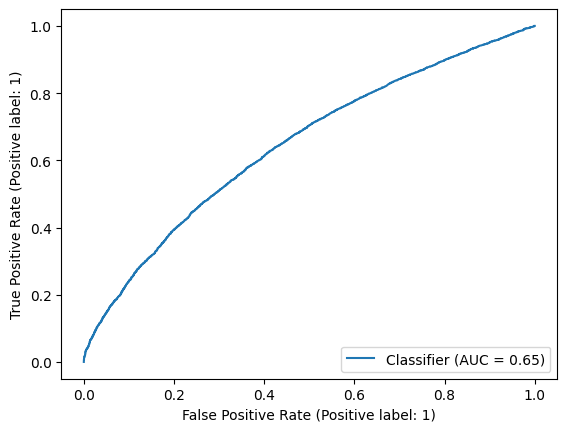

In [ ]:
create_display_ROC(scores_cif10_soft_adv_strong, scores_cif100_soft_adv_strong)

#### PR Curve


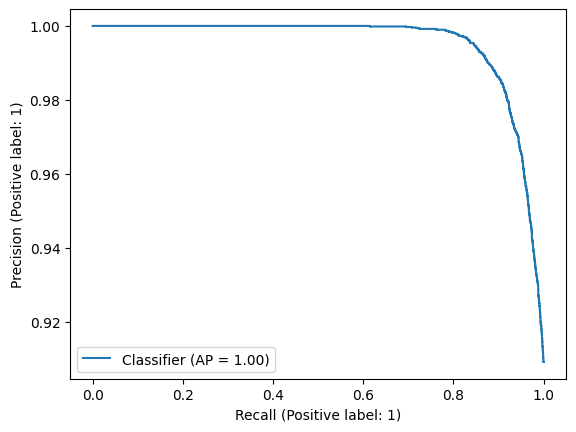

In [ ]:
create_display_PR(scores_cif10_adv_strong, scores_fake_adv_strong)

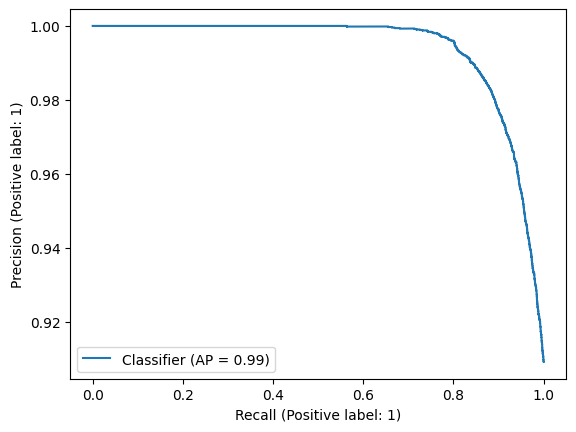

In [ ]:
create_display_PR(scores_cif10_soft_adv_strong, scores_fake_soft_adv_strong)

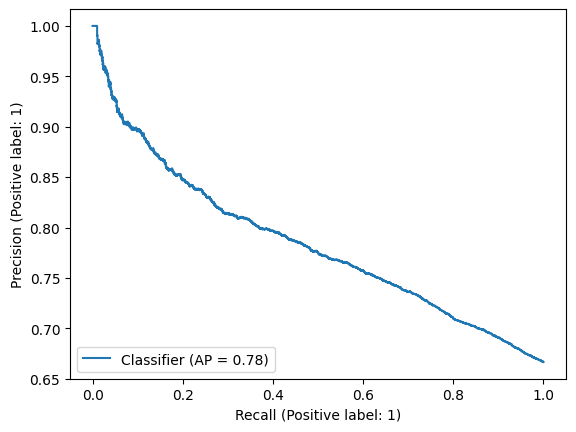

In [ ]:
create_display_PR(scores_cif10_adv_strong, scores_cif100_adv_strong)

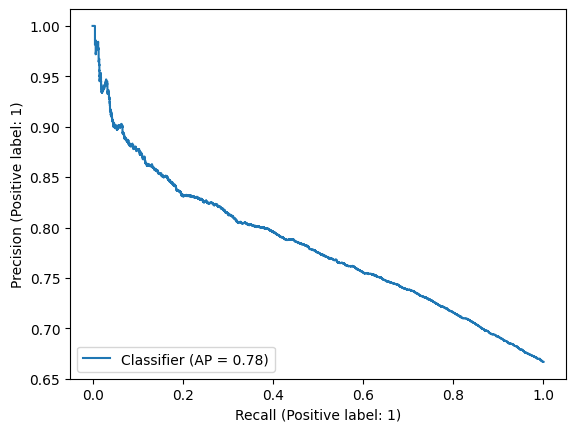

In [ ]:
create_display_PR(scores_cif10_soft_adv_strong, scores_cif100_soft_adv_strong)

This time the ROC and PR curves related to Fake Data are a little better than the ones in the previous subsection while the ROC and PR curves related to CIFAR100 are a little worse.

This behavior  reinforces the belief that training with attacked images makes the network more noise resistant and able to tell that an image is just noise, the heavier the attack the noisier the images.


#### Adversarial attacks
Testing the model trained with a heavy attack with a smaller attack and the same attack it was trained on.

Attack with a smaller epsilon

Original image and original predicted class


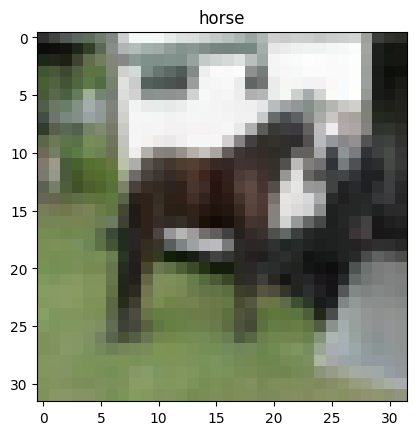

Image and predicted class after the adversarial attack


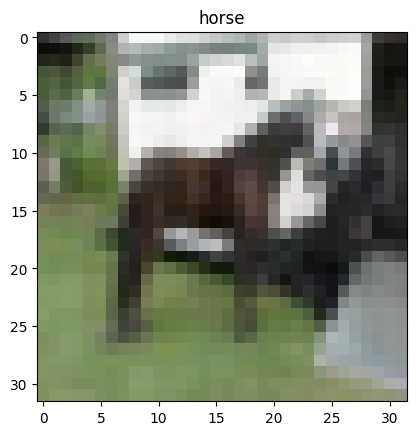

Absolute difference between the two images


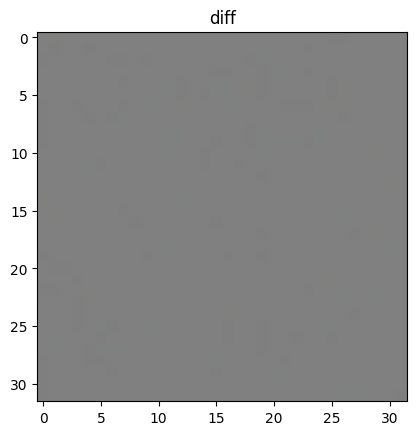

Histogram with the difference of the two images on a pixel level


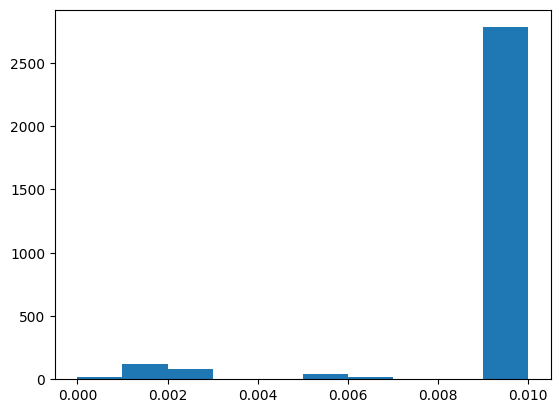

In [ ]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.002

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv_strong)

# Select a particular image to show the result
id_image=20
# Calculate first output of the model given the real image
first_out = model_adv_strong(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Test accuracy of the network: 51.93 %


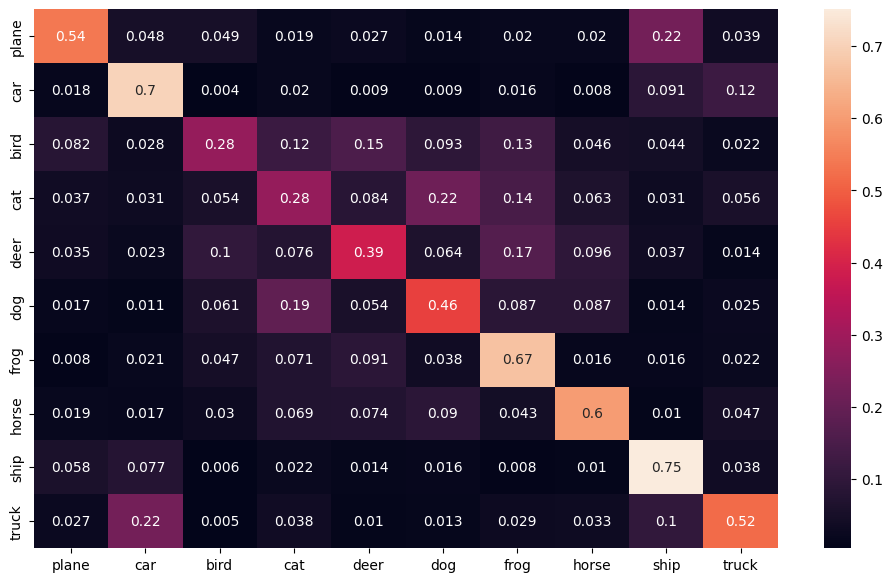

In [ ]:
# Test the model on attacked test images
testing(model_adv_strong, dl_test_cifar10, fgsm)

Attacking the test images with a weaker attack than the attack the network was trained with does only slightly deteriorate test accuracy (from 59.18% to 51.93%). The model is now very robust to what I considered the best attack (invisible and effective).

Attack with the same epsilon as the training


Original image and original predicted class


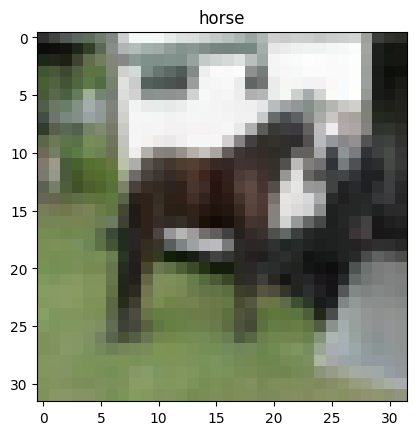

Image and predicted class after the adversarial attack


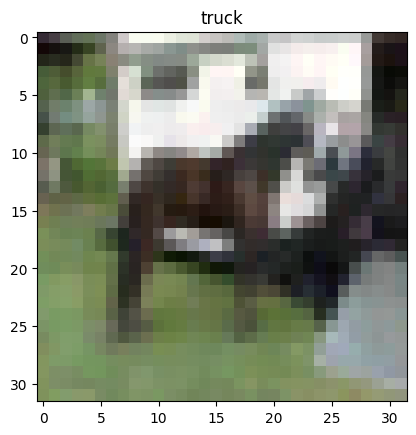

Absolute difference between the two images


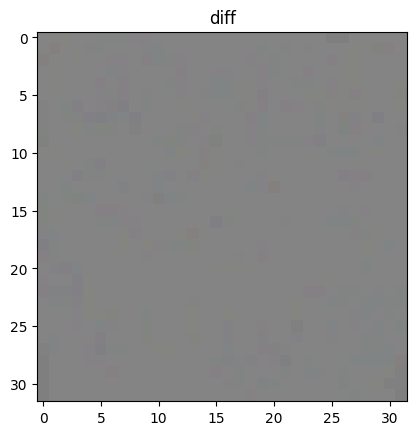

Histogram with the difference of the two images on a pixel level


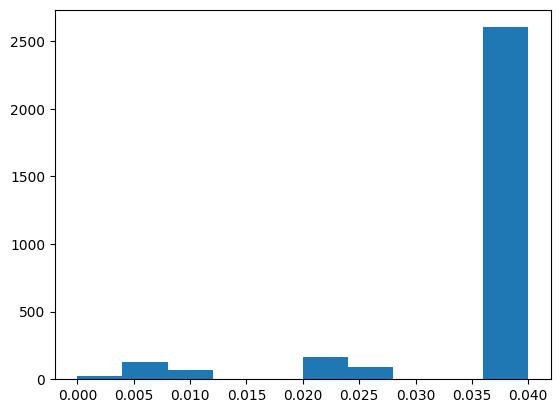

In [ ]:
# Small enough to not be able to distinguish between the original image and the attacked image
eps = 0.008

# Get some test images
for data in dl_test_cifar10:
    images, labels = data
    break

# Attack the images
fgsm = FGSM(epsilon = eps, num_steps = 5)
avd_images, outputs = fgsm.attack(images, labels, model_adv_strong)

# Select a particular image to show the result
id_image=20
# Calculate first output of the model given the real image
first_out = model_adv_strong(images.to(device))
# Print image, compare the assiged label before and after the attack
Compare_img(images[id_image], first_out[id_image], avd_images[id_image], outputs[id_image])

Test accuracy of the network: 31.93 %


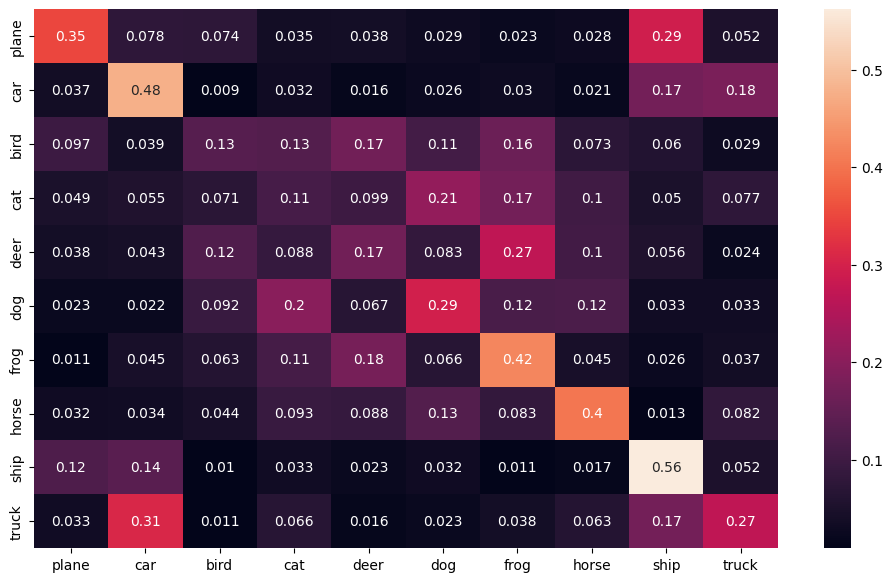

In [ ]:
# Test the model on attacked test images
testing(model_adv_strong, dl_test_cifar10, fgsm)

The model is pretty robust even to strong attacks (from 59.18% to 31.93% on test accuracy). This is a remarkable result considering that this kind of attack is indeed very strong (the default model achieved 5.05% test accuracy under the same attack) and extremely noticeable.

In conclusion using a stronger attack during training time seems like the best choice for robustness. The resulting model is more capable of resisting other adversarial attacks while not losing much on the classification accuracy (it may need a longer training given a harsher data augmentation).

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
